<a href="https://colab.research.google.com/github/abdulwaheedsoudagar/FruitsClassification/blob/master/FruitsClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abdulwaheedsoudagar","key":"955fbb2600914e400bdfd9122b570b28"}'}

In [0]:
! mkdir ~/.kaggle

In [0]:
! cp "kaggle.json" ~/.kaggle/

In [5]:
!kaggle datasets download -d moltean/fruits

 99% 721M/732M [00:14<00:00, 40.4MB/s]
100% 732M/732M [00:14<00:00, 51.4MB/s]


In [0]:
! mkdir train

In [7]:
! unzip fruits.zip -d train

Streaming output truncated to the last 5000 lines.
  inflating: train/fruits-360/Training/Tangelo/r_16_100.jpg  
  inflating: train/fruits-360/Training/Tangelo/r_17_100.jpg  
  inflating: train/fruits-360/Training/Tangelo/r_181_100.jpg  
  inflating: train/fruits-360/Training/Tangelo/r_182_100.jpg  
  inflating: train/fruits-360/Training/Tangelo/r_183_100.jpg  
  inflating: train/fruits-360/Training/Tangelo/r_184_100.jpg  
  inflating: train/fruits-360/Training/Tangelo/r_185_100.jpg  
  inflating: train/fruits-360/Training/Tangelo/r_186_100.jpg  
  inflating: train/fruits-360/Training/Tangelo/r_187_100.jpg  
  inflating: train/fruits-360/Training/Tangelo/r_188_100.jpg  
  inflating: train/fruits-360/Training/Tangelo/r_189_100.jpg  
  inflating: train/fruits-360/Training/Tangelo/r_18_100.jpg  
  inflating: train/fruits-360/Training/Tangelo/r_190_100.jpg  
  inflating: train/fruits-360/Training/Tangelo/r_191_100.jpg  
  inflating: train/fruits-360/Training/Tangelo/r_192_100.jpg  
  infla

In [0]:
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization
import os
import matplotlib.pyplot as plt
import numpy as np

In [0]:
train_data_dir = './train/fruits-360/Training'
validation_data_dir = './train/fruits-360/Test'

In [0]:
img_rows, img_cols = 32, 32
batch_size = 64

In [22]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 60486 images belonging to 120 classes.
Found 20618 images belonging to 120 classes.


In [0]:
num_classes = 120 

In [0]:
class CNN_Network:
	@staticmethod
	def build(width, height, depth, classes):
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1
		model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(3, 3)))
		model.add(Dropout(0.25))

		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
  
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
  
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		model.add(Flatten())
		model.add(Dense(1024))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		model.add(Dense(classes))
		model.add(Activation("softmax"))

		return model

In [0]:
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [0]:
checkpoint = ModelCheckpoint("./weights.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

In [0]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)
callbacks = [checkpoint, reduce_lr]

In [0]:
model = CNN_Network.build(width=32, height=32,depth=3, classes=num_classes)
opt = Adam()

In [0]:
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

In [0]:
nb_train_samples = 60486
nb_validation_samples = 20618
epochs = 20

In [54]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/20
945/945 [==============================] - ETA: 0s - loss: 1.7450 - accuracy: 0.5168
Epoch 00001: val_loss improved from inf to 1.98625, saving model to ./weights.h5
945/945 [==============================] - 63s 67ms/step - loss: 1.7450 - accuracy: 0.5168 - val_loss: 1.9863 - val_accuracy: 0.5663 - lr: 0.0010
Epoch 2/20
945/945 [==============================] - ETA: 0s - loss: 0.5921 - accuracy: 0.8037
Epoch 00002: val_loss improved from 1.98625 to 1.29099, saving model to ./weights.h5
945/945 [==============================] - 63s 67ms/step - loss: 0.5921 - accuracy: 0.8037 - val_loss: 1.2910 - val_accuracy: 0.6989 - lr: 0.0010
Epoch 3/20
945/945 [==============================] - ETA: 0s - loss: 0.4191 - accuracy: 0.8603
Epoch 00003: val_loss did not improve from 1.29099
945/945 [==============================] - 63s 67ms/step - loss: 0.4191 - accuracy: 0.8603 - val_loss: 1.9243 - val_accuracy: 0.6118 - lr: 0.0010
Epoch 4/20
945/945 [==============================] - ETA

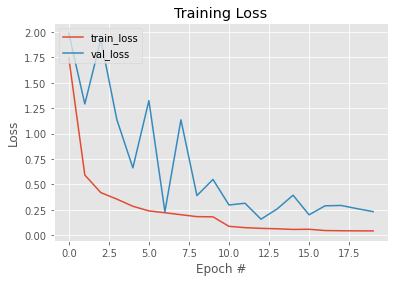

In [55]:
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper left")

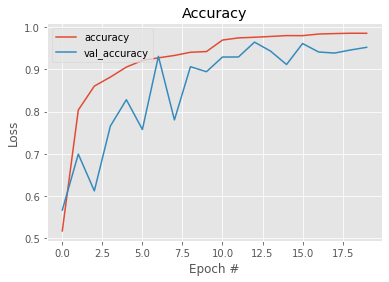

In [57]:
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["accuracy"], label="accuracy")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper left")

In [66]:
len(classes)

120